This notebook is used to analyze performance of a network of stores.  It's primary purposes are to
determine the best way to measure store or market based tests in a store network, and to 
identify performance outliers that contribute to measurement noise.

It includes functions to import data, visualize the data, conduct nulltest simulations to 
identify the best measurement approach for tests.  Then the notebook identifies store outliers, and measures the 
level of improvement that handling outliers creates.  Throughout, I'll provide markdown comments to discuss 
code that may need explanation, and interpretation of the results.

The code starts with python libraries used, along with a function used to parse dates in the dataset

In [60]:
#import libraries and create a function to parse dates in the dataset
#used to import_export csv
from pathlib import Path

#used to work with dataframes
import pandas as pd
from pandas import read_csv
import numpy as np

#parsing dates from data file
from datetime import datetime
from datetime import  timedelta

#correlation used in nulltest results, and similar sites creation
import scipy.stats
from scipy import stats
from scipy.stats import pearsonr

#for graphs and plots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

#random generator used in nulltests
import random

#create a function that parses dates
from dateutil import parser #date parsing function
"""This function takes in a date string, identifies the format, and returns a date type"""
def parse_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)
    except ValueError:
        # Handle cases where parsing fails
        return pd.NaT
    
import matplotlib.dates as mdates

Next, import the dataset, parse the dates, and create a new dataframe which is the sum of the sales for store departments.
There are ~99 departments in each store, that can be measured individually ore combined.  In this case, all of the analysis uses
the sales of all department sales summed.

In [3]:
#import the dataset
dataset_sales = read_csv("/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/sales_data.csv")
#dates are inconsistent - parse and convert to date format
dataset_sales['Date'] = dataset_sales['Date'].apply(parse_date)
#Convert sales to float
dataset_sales['Weekly_Sales'] = dataset_sales['Weekly_Sales'].astype(float)
#create a total store sales view.  This is sales summed by date & store
total_store_sales = pd.DataFrame()
total_store_sales = dataset_sales.groupby(['Date','Store'], as_index=False)['Weekly_Sales'].sum()
#create a chain sales view
chain_sales=dataset_sales.groupby(['Date'], as_index=False)['Weekly_Sales'].sum()
#save off a text file with total store sales
filepath = Path('/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/total_store_data.csv') 
total_store_sales.to_csv(filepath, index=False)


Next, investigate the histograme of average sales / store / week to look at seasonality.  First, define a store
histogram function, then call the function.  Note how the stores have a nearly order of magnitude sales difference
between the biggest and smallest ones.  The stores average $1M / store / week.  

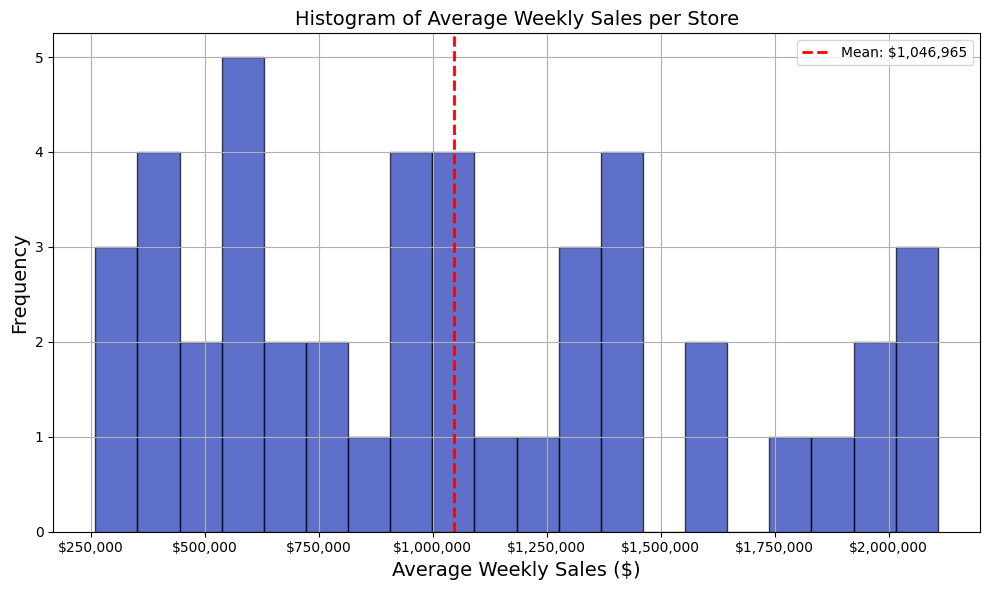

In [4]:
#define a function that displays store level histograms

def store_perf_histogram(sales_dataframe, show_mean=True, show_3sigma_outliers=False):
    """displays a histogram of sales performance by store for a given sales dataframe
    show_mean selects whether to display the mean
    show_3sigma_outliers selects whether to display positive and negative outliers"""
    # Group by 'Store' and calculate the mean 'Weekly_Sales' for each store
    average_weekly_sales = sales_dataframe.groupby('Store')['Weekly_Sales'].mean().reset_index()

    # Calculate the mean of the average weekly sales
    mean_sales = average_weekly_sales['Weekly_Sales'].mean()

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(average_weekly_sales['Weekly_Sales'], bins=20, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
    if show_mean:
        plt.axvline(mean_sales, color='red', linestyle='dashed', linewidth=2, label=f'Mean: ${mean_sales:,.0f}')
    if show_3sigma_outliers:
        stdev_sales = average_weekly_sales['Weekly_Sales'].std()
        plt.axvline(mean_sales+stdev_sales*3, color='gray', linestyle='dashed', linewidth=2, label=f'Outlier line positive: {mean_sales+stdev_sales*3:,.0f}')       
        plt.axvline(mean_sales-stdev_sales*3, color='gray', linestyle='dashed', linewidth=2,  label=f'Outlier line negative: {mean_sales-stdev_sales*3:,.0f}')       
    plt.title("Histogram of Average Weekly Sales per Store", fontsize=14)
    plt.xlabel("Average Weekly Sales ($)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()
    plt.grid(True)

    # Format the x-axis to show dollar signs and avoid scientific notation
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

    plt.tight_layout()
    plt.show()


#show histogram of store sales / wk performance
store_perf_histogram(total_store_sales, show_mean=True, show_3sigma_outliers=False)


Trend charts are going to be a theme of the analysis to identify store seasonality, growth trends, and outliers.  This function
averages all of the stores in a dataframe, and plots the result.  To start, I plotted sales for all stores in the network.
Note the seasonality.  The highest sales are during holidays, and those points are nearly 2x the average sales /wk.  The line of 
best fit shows whether the store is growing over time.

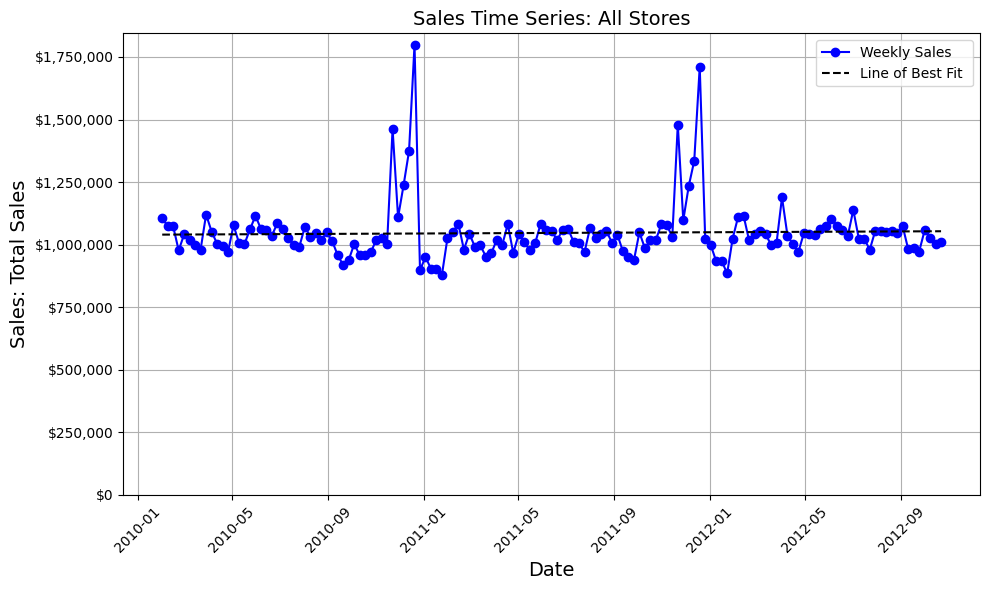

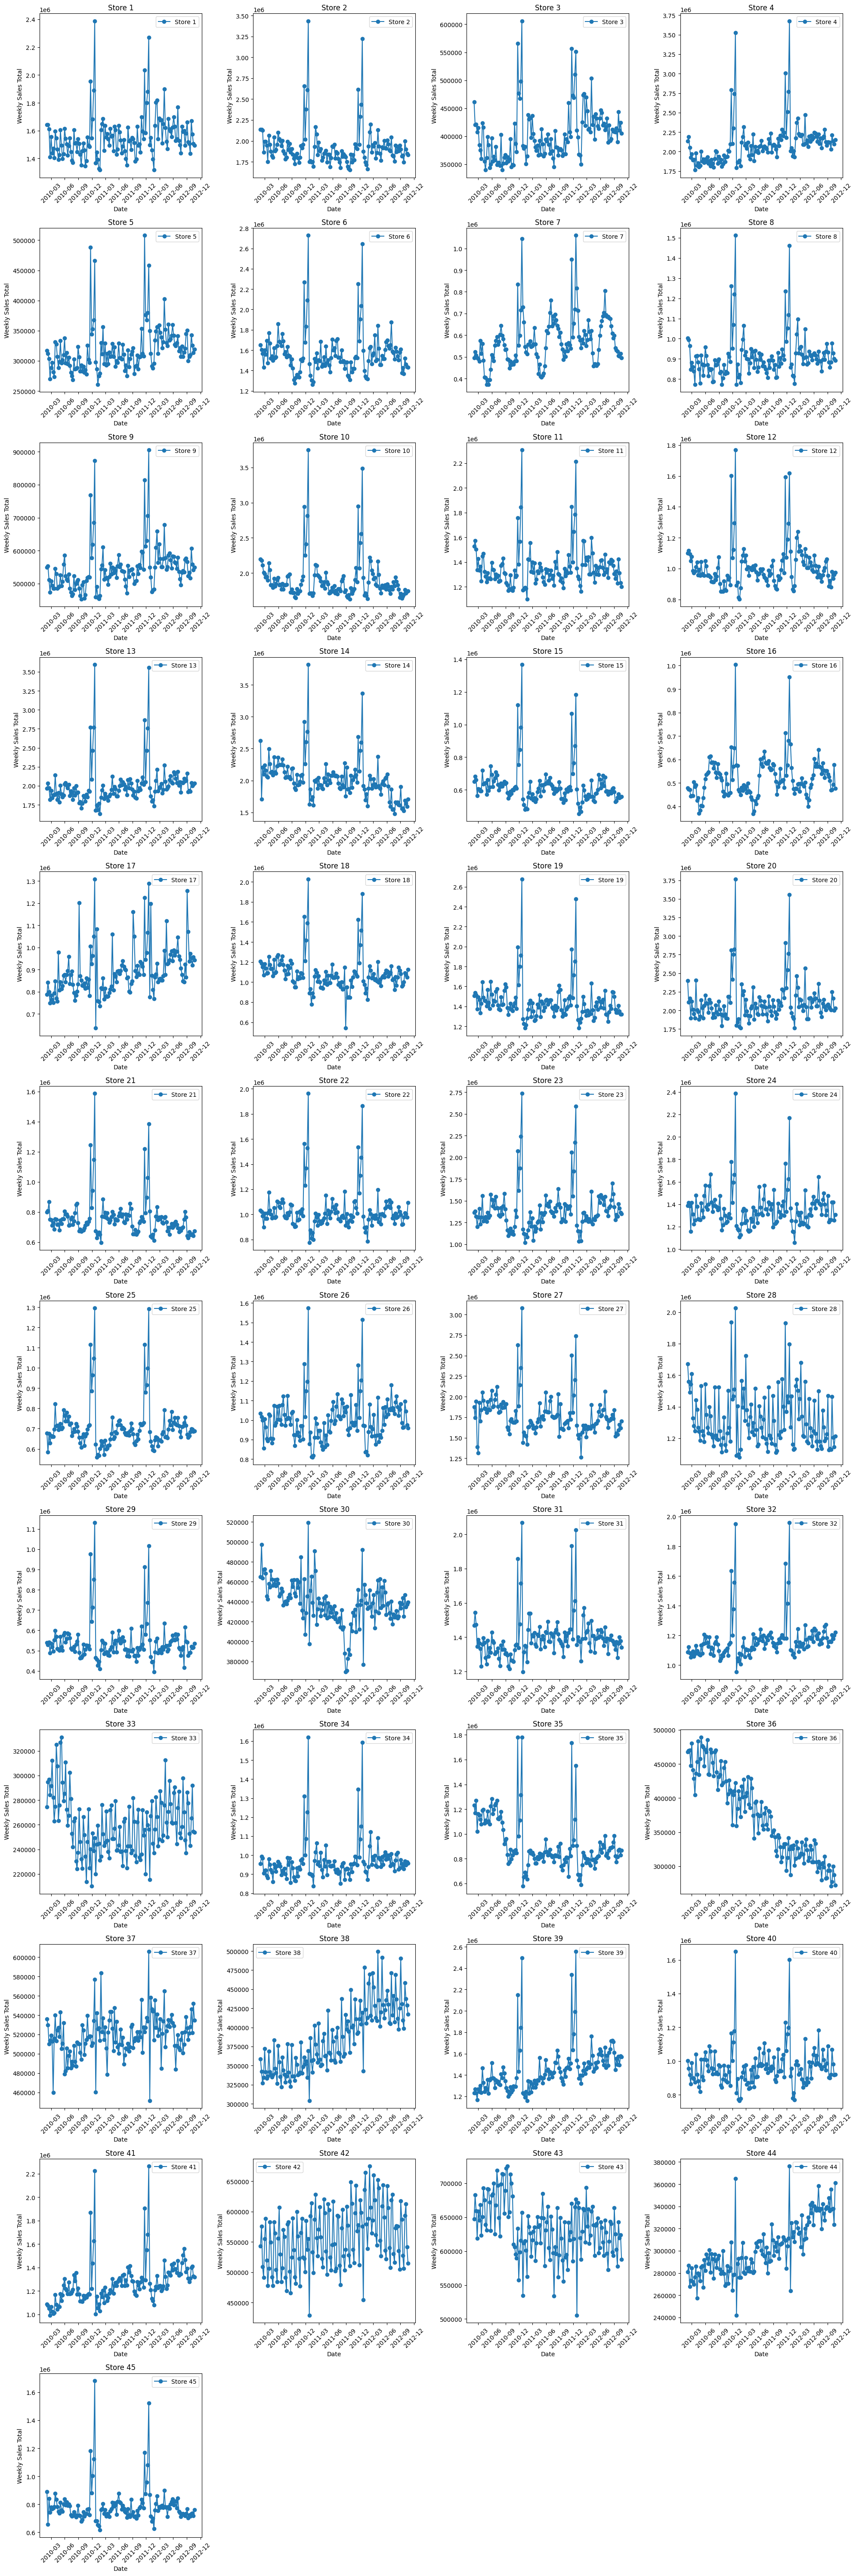

In [62]:
#trend chart functions

def trend_chart(sales_dataframe, category, store_set, trend_line=False, index_value=False):
    """Take in a sales dataframe and category name, plot the trend chart as a line graph with weekly average sales"""
    # Ensure the DataFrame has the necessary columns
    if 'Date' not in sales_dataframe.columns or 'Weekly_Sales' not in sales_dataframe.columns:
        raise ValueError("DataFrame must contain 'Date' and 'Weekly_Sales' columns.")
    
    # Convert 'Date' column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(sales_dataframe['Date']):
        sales_dataframe['Date'] = pd.to_datetime(sales_dataframe['Date'])
    
    # Ensure the 'Date' column is set to the start of the week
    sales_dataframe['Date'] = sales_dataframe['Date'] - pd.to_timedelta(sales_dataframe['Date'].dt.weekday, unit='d')
    
    # Group by 'Date' and calculate the mean 'Weekly_Sales' for each week
    weekly_sales = sales_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()

    #create trend line if requested
    # Calculate the line of best fit
    if trend_line:
        weekly_sales['Date_num'] = pd.to_numeric(weekly_sales['Date'])
        coefficients = np.polyfit(weekly_sales['Date_num'], weekly_sales['Weekly_Sales'], 1)
        poly = np.poly1d(coefficients)
        weekly_sales['Trendline'] = poly(weekly_sales['Date_num'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label = 'Weekly Sales', color='blue', marker='o', linestyle='-')
    if trend_line:
        plt.plot(weekly_sales['Date'], weekly_sales['Trendline'], label='Line of Best Fit ', linestyle='--', color='black')
    plt.title(f"Sales Time Series: {store_set}", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Sales: {category}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Ensure y-axis displays integer values with dollar signs
    ax = plt.gca()
    if not index_value:
        ax.set_ylim(bottom=0) 
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))
    plt.tight_layout()
    plt.show()



def multiple_trend_charts(dataframe, plots_per_row=4):
    # Ensure the DataFrame has the necessary columns
    if 'Store' not in dataframe.columns or 'Date' not in dataframe.columns or 'Weekly_Sales' not in dataframe.columns:
        raise ValueError("DataFrame must contain 'Store', 'Date', and 'Weekly_Sales' columns.")
    
    # Convert 'Date' column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(dataframe['Date']):
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    
    # Get unique stores
    stores = dataframe['Store'].unique()
    
    # Number of plots
    num_stores = len(stores)
    num_rows = (num_stores + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for idx, store in enumerate(stores):
        ax = axes[idx]
        store_data = dataframe[dataframe['Store'] == store]
        ax.plot(store_data['Date'], store_data['Weekly_Sales'], marker='o', linestyle='-', label=f'Store {store}')
        ax.set_title(f'Store {store}', fontsize=12)
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Weekly Sales Total', fontsize=10)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
    
    # Hide any empty subplots
    for idx in range(num_stores, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()


#trend chart of average total store sales time series
trend_chart(total_store_sales, "Total Sales", "All Stores", trend_line=True, index_value=False)

#print individual trend charts for each store
multiple_trend_charts(total_store_sales, 4)


The same function can be used to investigate any store or set of stores. Store 19 has similar seasonal patterns as the rest of the network
and store 36 has unique sales patterns.  It also appears to be declining over time.

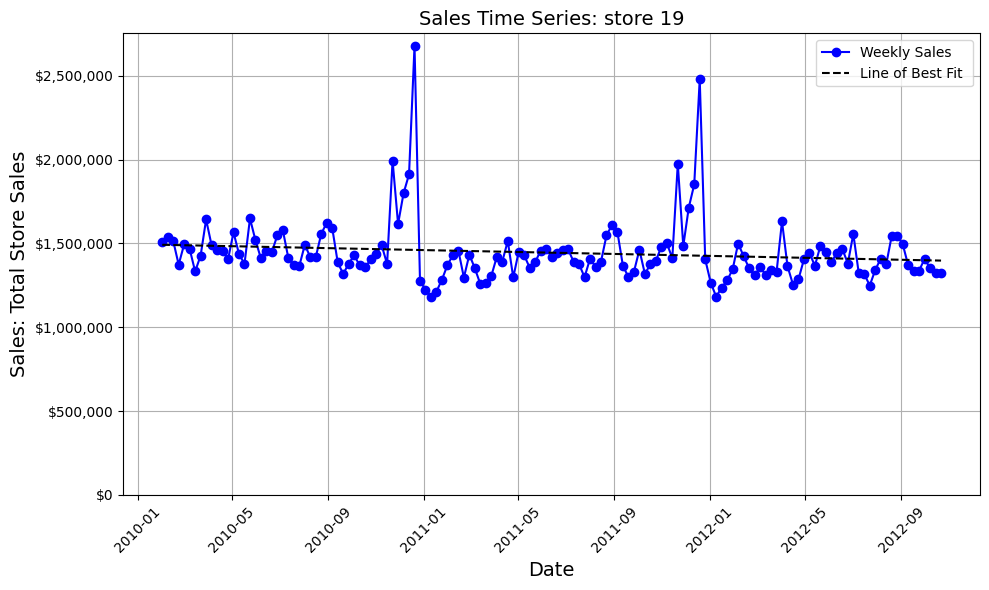

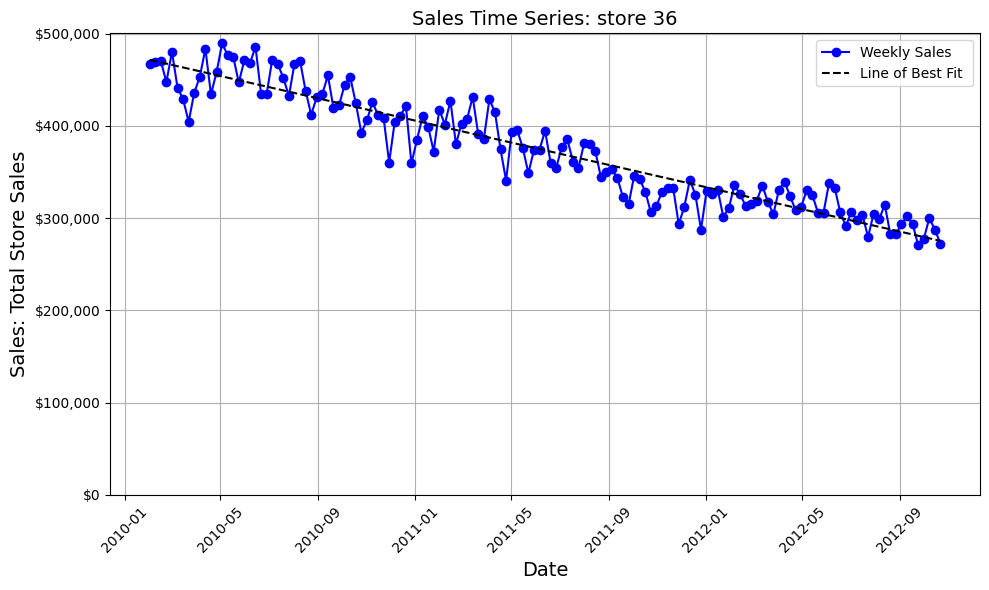

In [49]:
#individual store trend exploration, store comparisons
store_trend = 19
store_trend_df = total_store_sales[(total_store_sales['Store'] == store_trend)].copy()
trend_chart(store_trend_df, "Total Store Sales", store_set = f"store {store_trend}", trend_line=True, index_value=False)

store_trend = 36
store_trend_df = total_store_sales[(total_store_sales['Store'] == store_trend)].copy()
trend_chart(store_trend_df, "Total Store Sales", store_set = f"store {store_trend}", trend_line=True, index_value=False)



Sometimes it is useful to compare store performance.  This trend chart function takes in 2 sales dataframes and creates a trend chart
out of each of them.  To be able to compare the growth and seaonality most effectively, each store is indexed to its own average
sales-1.  The mean value of the time series for each is 0.

           Date  Store  Weekly_Sales
20   2010-02-01     21     798593.88
65   2010-02-08     21     809321.44
110  2010-02-15     21     867283.25
155  2010-02-22     21     749597.24
200  2010-03-01     21     747444.32
...         ...    ...           ...
6230 2012-09-24     21     647097.65
6275 2012-10-01     21     651768.91
6320 2012-10-08     21     653043.44
6365 2012-10-15     21     641368.14
6410 2012-10-22     21     675202.87

[143 rows x 3 columns]


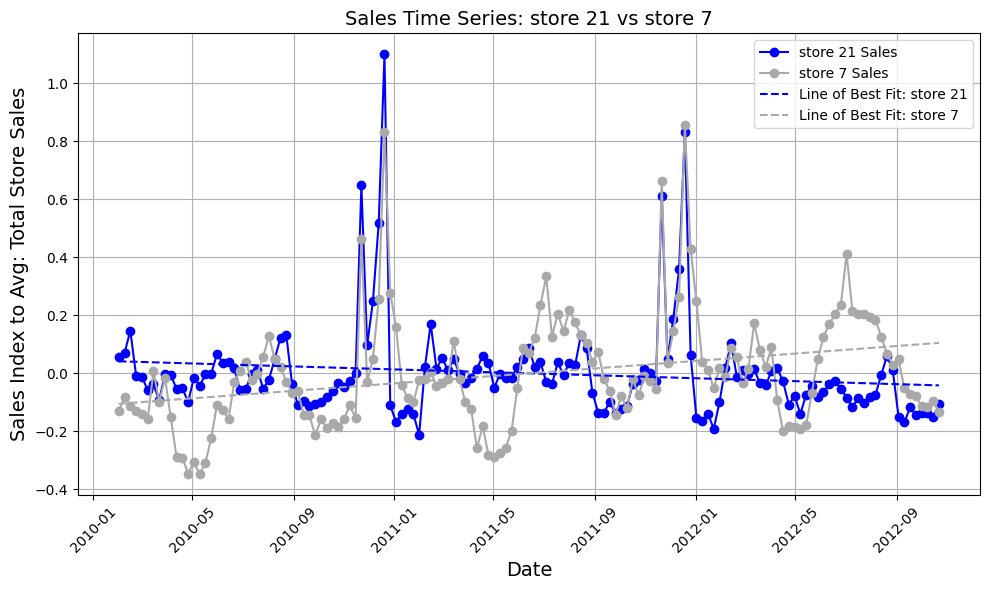

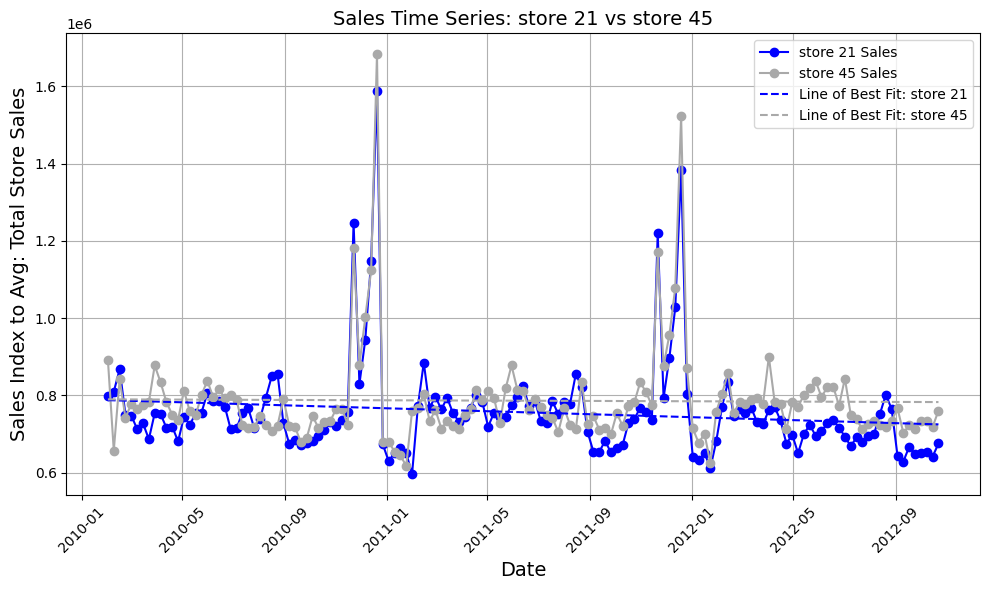

In [14]:
#trend chart comparisons of stores ore store groups

def trend_chart_comparison(sales_dataframe, comparison_dataframe, category, store_set_1, store_set_2, trend_line=False, index_value=False):
    """Plot sales trend chart with outliers for a store along with a comparison store's sales trend."""

    # Ensure the DataFrame has the necessary columns
    for df in [sales_dataframe, comparison_dataframe]:
        if 'Date' not in df.columns or 'Weekly_Sales' not in df.columns:
            raise ValueError("Both DataFrames must contain 'Date' and 'Weekly_Sales' columns.")
    
    # Convert 'Date' columns to datetime if they're not already
    for df in [sales_dataframe, comparison_dataframe]:
        if not pd.api.types.is_datetime64_any_dtype(df['Date']):
            df['Date'] = pd.to_datetime(df['Date'])
    
    # Ensure the 'Date' columns are set to the start of the week
    for df in [sales_dataframe, comparison_dataframe]:
        df['Date'] = df['Date'] - pd.to_timedelta(df['Date'].dt.weekday, unit='d')
    
    # Group by 'Date' and calculate the mean 'Weekly_Sales' for each week
    weekly_sales = sales_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()
    weekly_comparison = comparison_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()

    # Create trend lines if requested
    if trend_line:
        weekly_sales['Date_num'] = pd.to_numeric(weekly_sales['Date'])
        coefficients = np.polyfit(weekly_sales['Date_num'], weekly_sales['Weekly_Sales'], 1)
        poly = np.poly1d(coefficients)
        weekly_sales['Trendline'] = poly(weekly_sales['Date_num'])
        weekly_comparison['Date_num'] = pd.to_numeric(weekly_comparison['Date'])
        coefficients = np.polyfit(weekly_comparison['Date_num'], weekly_comparison['Weekly_Sales'], 1)
        poly = np.poly1d(coefficients)
        weekly_comparison['Trendline'] = poly(weekly_comparison['Date_num'])
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label= f'{store_set_1} Sales', color='blue', marker='o', linestyle='-')
    plt.plot(weekly_comparison['Date'], weekly_comparison['Weekly_Sales'], label=f'{store_set_2} Sales', color='darkgray', marker='o', linestyle='-')
    
    # Plot trend lines if requested
    if trend_line:
        plt.plot(weekly_sales['Date'], weekly_sales['Trendline'], label=f'Line of Best Fit: {store_set_1}', linestyle='--', color='blue')
        plt.plot(weekly_comparison['Date'], weekly_comparison['Trendline'], label=f'Line of Best Fit: {store_set_2}', linestyle='--', color='darkgray')
    
    plt.title(f"Sales Time Series: {store_set_1} vs {store_set_2}", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Sales Index to Avg: {category}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Ensure y-axis displays integer values with dollar signs
    ax = plt.gca()
    if not index_value:
        ax.set_ylim(bottom=0) 
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))
    plt.tight_layout()
    plt.show()

#choose stores to compare their sales
store1_trend = 21
store2_trend = 7
store1_trend_df = total_store_sales[(total_store_sales['Store'] == store1_trend)].copy()
store2_trend_df = total_store_sales[(total_store_sales['Store'] == store2_trend)].copy()
store1_trend_df_avg = store1_trend_df['Weekly_Sales'].mean()
store2_trend_df_avg = store2_trend_df['Weekly_Sales'].mean()
store1_trend_df['Weekly_Sales'] = store1_trend_df['Weekly_Sales'] / store1_trend_df_avg - 1
store2_trend_df['Weekly_Sales'] = store2_trend_df['Weekly_Sales'] / store2_trend_df_avg - 1
trend_chart_comparison(store1_trend_df, store2_trend_df, "Total Store Sales", store_set_1 = f"store {store1_trend}", store_set_2 = f"store {store2_trend}", trend_line=True, index_value=True)


store1_trend = 21
store2_trend = 45
store1_trend_df = total_store_sales[(total_store_sales['Store'] == store1_trend)].copy()
store2_trend_df = total_store_sales[(total_store_sales['Store'] == store2_trend)].copy()
store1_trend_df_avg = store1_trend_df['Weekly_Sales'].mean()
store2_trend_df_avg = store2_trend_df['Weekly_Sales'].mean()
store1_trend_df['Weekly_Sales'] = store1_trend_df['Weekly_Sales'] / store1_trend_df_avg - 1
store2_trend_df['Weekly_Sales'] = store2_trend_df['Weekly_Sales'] / store2_trend_df_avg - 1
trend_chart_comparison(store1_trend_df, store2_trend_df, "Total Store Sales", store_set_1 = f"store {store1_trend}", store_set_2 = f"store {store2_trend}", trend_line=True, index_value=True)

4 functions are used to pair test stores with a matched control .

store_sales_similarity - uses pre-period store sales correlation and trending to return a matching quality score between all of the stores.
store_sales_similarity_ly - uses last year's pre and testing period timelines to return a matching similarity score between all of the
    stores.  this is a score involving the specific timelines of hte test in the prior year for a direct seasonality match.
similar_sites_pairing - uses scoring from the two functions above to assign a specified number of control sites to each test site.
similar_sites_pairing_correlmin - similar to above, but will stop making matches if the test/conntrol relationship becomes poor.

In [50]:
#test and control store matching functions

def similar_sites_pairing_correlmin(site_pair_scores, test_sites, control_sites, correl_min, max_simsites, min_simsites):
    """Pass in a list of site pair scores, the list of test stores, the list of control stores and
    return a dataframe of test site and control site matches.  
    Can match > 1 control site per test site.  Can re-use conntrol sites.  
    correl_min = minimum acceptable fit score between test and control stores.  between 0 and 1.
    max_simsites = maximum acceptable count of control stores per test store 
    min_simsites = minimum acceptable countn of control stores per test store.  Over-rides the minimum acceptable fit.
    """
    match_df = pd.DataFrame()
    for target_store in test_sites['target_store'].unique():
        store_slice = site_pair_scores[site_pair_scores['target_store'] == target_store].copy()
        
        # Remove target/test stores from the pool of controls
        control_store_set = set(control_sites['control_pool_store'])
        store_slice = store_slice[store_slice['paired_store'].isin(control_store_set)]
        
        # Order control from best to worst match
        sorted_slice = store_slice.sort_values(by='correlation', ascending=False)
        
        simsites = 0
        while not sorted_slice.empty and (simsites < max_simsites) and (simsites < min_simsites or sorted_slice.iloc[0]['correlation'] > correl_min):
            best_match = sorted_slice.iloc[0]
            match_df = pd.concat([match_df, best_match.to_frame().T])
            sorted_slice = sorted_slice.iloc[1:]
            simsites += 1
        
        if sorted_slice.empty and simsites < min_simsites:
            print(f"Unable to find a sufficient number of similar sites for {target_store}.")
    
    return match_df

def similar_sites_pairing(site_pair_scores, test_sites, control_sites, pairing_num):
    """Pass in a list of site pair scores, the list of test stores, the list of control stores
    return a dataframe of test site and control site matches.  
    Can match > 1 control site per test site.  Can re-use conntrol sites.  
    pairing_num is the number of control sites to assign to each test site.  
    """
    match_df = pd.DataFrame()
    for target_store in test_sites['target_store'].unique():
        store_slice = site_pair_scores[site_pair_scores['target_store'] == target_store].copy()
        
        # Remove target stores from the pool of controls
        control_store_set = set(control_sites['control_pool_store'])
        store_slice = store_slice[store_slice['paired_store'].isin(control_store_set)]
        
        # Get the top N pairings
        sorted_slice = store_slice.sort_values(by='correlation', ascending=False).head(pairing_num)
        match_df = pd.concat([match_df, sorted_slice])
    
    return match_df

#pre period store similarity function
def store_sales_similarity(store_sales, start_date, end_date, correl_weight):
    """Pass this function a dataframe of stores sales and dates. Will score the similarity of every site against every 
    other site for the timeframe specfied between the start date and end date
    correl_weight - indicates the relative influenc of correlation or trend_slope on the match score. correl_weight of 0 means 100% trend match.
    """
    #select data during the desired period
    data_time_slice = store_sales[(store_sales['Date'] >= start_date) & (store_sales['Date'] <= end_date)].copy()
    data_time_slice.sort_values(by=['Date'], inplace=True)
    #select the list of all stores in the data
    store_nums = data_time_slice['Store'].unique()
    
    results = []
    #nested loop - every store is compared with every other store
    for target_store in store_nums:
        target_store_slice = data_time_slice[data_time_slice['Store'] == target_store].copy()
        target_slope, target_intercept = np.polyfit(np.arange(len(target_store_slice)), target_store_slice['Weekly_Sales'], 1)
        target_slope = target_slope / target_store_slice['Weekly_Sales'].mean()
        
        for paired_store in store_nums:
            if target_store != paired_store:
                paired_store_slice = data_time_slice[data_time_slice['Store'] == paired_store].copy()
                #the slope of line of best fit is the trend used in the slope part of matching
                paired_slope, paired_intercept = np.polyfit(np.arange(len(paired_store_slice)), paired_store_slice['Weekly_Sales'], 1)
                paired_slope = paired_slope / paired_store_slice['Weekly_Sales'].mean()

                slope_score = 1 - abs(target_slope - paired_slope)
                #correlation between each sites sales trend over the selected period
                correl_result = stats.pearsonr(target_store_slice['Weekly_Sales'], paired_store_slice['Weekly_Sales'])[0]
                #overall match is a weighted funnction of correlation and slope, weight depends on the correl_weight variable
                match_score = correl_weight * correl_result + (1-correl_weight) * slope_score
                results.append((target_store, paired_store, match_score))
    
    site_pair_scores = pd.DataFrame(results, columns=['target_store', 'paired_store', 'correlation'])
    return site_pair_scores


#TYLY store pair simiilarity function
def store_sales_similarity_ly(store_sales, pre_start, pre_end, post_start, post_end):
    """Pass this function a dataframe of stores sales along with the start and end dates of pre and testing period
    The functiion will score site similarty on sales performance changes last year during the pre and post periods
    Returns similarity scores for every site pairing combination
    """
    ly_length = timedelta(days=int(364))
    data_time_slice_pre = store_sales[(store_sales['Date']  >= pre_start - ly_length ) & (store_sales['Date'] <= pre_end - ly_length )].copy()
    data_time_slice_post = store_sales[(store_sales['Date']  >= post_start - ly_length) & (store_sales['Date']  <= post_end - ly_length)].copy()
    store_nums = data_time_slice_pre['Store'].unique()
    
    results = []
    for target_store in store_nums:
        target_store_slice_pre = data_time_slice_pre[data_time_slice_pre['Store'] == target_store].copy()
        target_store_slice_post = data_time_slice_post[data_time_slice_post['Store'] == target_store].copy()
        for paired_store in store_nums:
            if target_store != paired_store:
                paired_store_slice_pre = data_time_slice_pre[data_time_slice_pre['Store'] == paired_store].copy()
                paired_store_slice_post = data_time_slice_post[data_time_slice_post['Store'] == paired_store].copy()
                match_score = 1-abs((target_store_slice_post['Weekly_Sales'].mean() / target_store_slice_pre['Weekly_Sales'].mean()) - (paired_store_slice_post['Weekly_Sales'].mean() / paired_store_slice_pre['Weekly_Sales'].mean()) )
                results.append((target_store, paired_store, match_score))
    
    site_pair_scores = pd.DataFrame(results, columns=['target_store', 'paired_store', 'correlation'])
    return site_pair_scores




This function is passed a list of stores and a count of x test stores.  it then selects a random set of x stores, and the balance of
the stores are returned as control stores

In [51]:
#simulator function to create random test stores
def create_random_test_stores(stores_df, num_test=5):
    """Creates a set of randomly selected test stores.  Returns a dataframe of test stores 
    and a dataframe of the remaining stores referred to as control sites
    num_test is the number of random test stores to select.  It defaults to 5
    """
    all_stores = list(set(stores_df['Store']))
    random_test_list = []
    #make random test selections
    while True:
        random_store = random.choice(all_stores)
        if(random_store not in random_test_list):
            random_test_list.append(random_store)
        if(len(random_test_list)>=num_test):
            break
    test_sites = pd.DataFrame(random_test_list)
    test_sites.columns = ['Store']
    #create an all stores list and remove test sites from the list to make control
    all_stores_df = pd.DataFrame(list(set(stores_df['Store'])))
    all_stores_df.columns = ['Store']
    control_sites = pd.merge(all_stores_df['Store'], test_sites['Store'], how='outer', indicator=True)
    control_sites = control_sites.loc[control_sites._merge == 'left_only', ['Store']]
    test_sites.columns = ['target_store']
    control_sites.columns = ['control_pool_store']
    return(test_sites, control_sites)




I created a simple class, SimResult, to store each simulation's parameters and test results.  There will be one instance of the class for a 
set of parameters.  A single instance of the class then contains a list of individual nulltest results.

In [52]:
#define a class to store the simulation results
class SimResult:
    """This class stores the parameter description for, results of a simulation run.  """
    def __init__(self, test_descrip, results):
        self.test_descrip = test_descrip
        self.results = results

class OutlierTrack:
    """This class stores the outliers for a given store.  """
    def __init__(self, store, outlier_dates):
        self.store = store
        self.outlier_dates = outlier_dates

Define functions to measure the impact of a test. One is a TYLY function that uses data from last year to help adjust for differences
in test and control seasonality.

In [53]:
#test measurement functions for pre vs testing period, and TYLY
def measurement(match_df, sales_df, pre_period_start, pre_period_end, post_period_start, post_period_end):
    """Measures the impact of tests.  
    input is the test and control matches dataframe, the sales dataframe, and timeframes for the analysis.
    output is a lift and p-value calculation
    """
    # Precompute slices
    pre_slice = sales_df[(sales_df['Date'] >= pre_period_start) & (sales_df['Date'] <= pre_period_end)].copy()
    post_slice = sales_df[(sales_df['Date'] >= post_period_start) & (sales_df['Date'] <= post_period_end)].copy()

    # Initialize lists for results
    pre_values_test = []
    post_values_test = []
    pre_values_control = []
    post_values_control = []
    expected_values = []

    # Get unique test stores
    test_stores = match_df['target_store'].unique()

    for target_store in test_stores:
        # Calculate test store sales
        store_pre_slice = pre_slice[pre_slice['Store'] == target_store]
        store_post_slice = post_slice[post_slice['Store'] == target_store]
        pre_sales_test = store_pre_slice['Weekly_Sales'].mean()
        post_sales_test = store_post_slice['Weekly_Sales'].mean()
        pre_values_test.append(pre_sales_test)
        post_values_test.append(post_sales_test)

        # Calculate control store sales
        store_control_list = match_df[match_df['target_store'] == target_store]
        control_stores = store_control_list['paired_store'].unique()
        
        control_pre_sales = pre_slice[pre_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_post_sales = post_slice[post_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        
        pre_avg_control = control_pre_sales.mean()
        post_avg_control = control_post_sales.mean()
        
        pre_values_control.append(pre_avg_control)
        post_values_control.append(post_avg_control)
        
        # Calculate expected values
        expected_values.append(pre_sales_test * (post_avg_control / pre_avg_control))
    
    # Statistical test
    t, p = stats.ttest_rel(post_values_test, expected_values)
    
    # Calculate lift
    lift = (sum(post_values_test) - sum(expected_values)) / sum(expected_values)
    
    return lift, p


def measurement_tyly(match_df, sales_df, pre_period_start, pre_period_end, post_period_start, post_period_end):
    """Measures the impact of test measured using TYLY approach
    input is the test and control matches dataframe, the sales dataframe, and timeframes for the analysis.
    output is a lift and p-value calculation
    """
    ly_length = timedelta(days=int(364))
    # Precompute slices
    pre_slice = sales_df[(sales_df['Date'] >= pre_period_start) & (sales_df['Date'] <= pre_period_end)].copy()
    post_slice = sales_df[(sales_df['Date'] >= post_period_start) & (sales_df['Date'] <= post_period_end)].copy()
    pre_slice_ly = sales_df[(sales_df['Date'] >= pre_period_start - ly_length) & (sales_df['Date'] <= pre_period_end - ly_length)].copy()
    post_slice_ly = sales_df[(sales_df['Date'] >= post_period_start - ly_length) & (sales_df['Date'] <= post_period_end - ly_length)].copy()

    # Initialize lists for results
    pre_values_test_list = []
    post_values_test_list = []
    pre_values_control_list = []
    post_values_control_list = []
    pre_values_test_ly_list = []
    post_values_test_ly_list = []
    pre_values_control_ly_list = []
    post_values_control_ly_list = []
    expected_values_list = []

    # Get unique test stores
    test_stores = match_df['target_store'].unique()

    for target_store in test_stores:
        # Calculate test store sales
        store_pre_slice = pre_slice[pre_slice['Store'] == target_store].copy()
        store_post_slice = post_slice[post_slice['Store'] == target_store].copy()
        store_pre_slice_ly = pre_slice_ly[pre_slice_ly['Store'] == target_store].copy()
        store_post_slice_ly = post_slice_ly[post_slice_ly['Store'] == target_store].copy()
        pre_sales_test = store_pre_slice['Weekly_Sales'].mean()
        post_sales_test = store_post_slice['Weekly_Sales'].mean()
        pre_sales_test_ly = store_pre_slice_ly['Weekly_Sales'].mean()
        post_sales_test_ly = store_post_slice_ly['Weekly_Sales'].mean()
        pre_values_test_list.append(pre_sales_test)
        post_values_test_list.append(post_sales_test)
        pre_values_test_ly_list.append(pre_sales_test_ly)
        post_values_test_ly_list.append(post_sales_test_ly)

        # Calculate control store sales
        store_control_list = match_df[match_df['target_store'] == target_store]
        control_stores = store_control_list['paired_store'].unique()
        
        control_pre_sales = pre_slice[pre_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_post_sales = post_slice[post_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_pre_sales_ly = pre_slice_ly[pre_slice_ly['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_post_sales_ly = post_slice_ly[post_slice_ly['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        
        pre_avg_control = control_pre_sales.mean()
        post_avg_control = control_post_sales.mean()
        pre_avg_control_ly = control_pre_sales_ly.mean()
        post_avg_control_ly = control_post_sales_ly.mean()
        
        pre_values_control_list.append(pre_avg_control)
        post_values_control_list.append(post_avg_control)
        pre_values_control_ly_list.append(pre_avg_control_ly)
        post_values_control_ly_list.append(post_avg_control_ly)
        
        #print("control", pre_avg_control, post_avg_control, pre_avg_control_ly, post_avg_control_ly)
        #print("test", pre_sales_test, post_sales_test, pre_sales_test_ly, post_sales_test_ly)

        # Calculate expected values
        expected_values_list.append(pre_sales_test * (post_sales_test_ly / pre_sales_test_ly) * ((post_avg_control / pre_avg_control) / (post_avg_control_ly / pre_avg_control_ly)))

    # Statistical test
    t, p = stats.ttest_rel(post_values_test_list, expected_values_list)
    
    # Calculate lift
    lift = (sum(post_values_test_list) - sum(expected_values_list)) / sum(expected_values_list)
    
    return lift, p



This is the nulltest simulator.  It randomly selects stores and a testing date based on parameters it is given.  The 
simulation results are passed back as a list of SimResult objects.

for each simulation iteration (ie, 100's of iterations per each test parameter)
The simulator calls functions to select random dates, and test and control stores
then score and select the best control matches for each test store.  
then measure the impact of the null test
then store the the iteration result

In [54]:
#simulator function

#pre vs testing period simulator
def simulator(sales_df, test_plan_df, pre_length, post_length, num_iterations=1, num_test_sites=5):
    """Runs simulations for a provided set of test plans provided through a dataframe.  A sales dataframe is also passed.
    
    Returns a list of SimResult class objects

    Test plan df has the following columns: 
        correl_min = minimum acceptable fit score between test and control stores.  between 0 and 1.
        max_simsites = maximum acceptable count of control stores per test store 
        min_simsites = minimum acceptable countn of control stores per test store.  Over-rides the minimum acceptable fit.
        correl_weight = How influential is correlation to the fit score relative to trend line similarity.  between 0 and 1
        match_type = determines if the minimum correlation approach is used, or if the same number of simsites are selected 
            regardless of fit quality.  select the min correlation approach with a value of min_correl
        TYLY_measurement_flag = indicates if the TYLY approach is used for measuring the test
        LY_match_flag

    Additional simulator specifications are passed as arguments to this function directly
    pre length = pre period length in days
    post length = post period length in days
    num_iterations = how many monte carlo simulations per row of the test plan
    Num test sites = how many test sites to select per simulation run
    """
    
    # potentially limit date selection to ensure similar timing with TYLY version
    yoy_match_timing = timedelta(days=364)

    # Determine viable dates
    results = []
    dates_df = pd.DataFrame(sales_df['Date'].unique(), columns=['Date']).sort_values(by='Date')
    stores_df = pd.DataFrame(sales_df['Store'].unique(), columns=['Store'])

    #1 day delay between pre and post periods
    time_between_pre_post = timedelta(days=1)

    #check sales data for min and max dates, to calculate viable dates for the simulation
    min_date = dates_df['Date'].iloc[0]
    max_date = dates_df['Date'].iloc[-1]
    pre_length = timedelta(days=int(pre_length))
    post_length = timedelta(days=int(post_length))

    #timeframe to be able to calculate last year values
    ly_length = timedelta(days=int(364))

    #calculate the viable start dates for the test
    min_pre_start = min_date + ly_length 
    max_pre_start = max_date - post_length - pre_length - time_between_pre_post
    if max_pre_start < min_pre_start:
        print(f"There are no viable dates where pre_length is {pre_length}, match length is {match_length}, \
                and post length is {post_length}")   
        breakpoint
    for idx, row in test_plan_df.iterrows():
        #figure out viable dates to select from 
        viable_pre_start_df = dates_df[(dates_df['Date'] > min_pre_start) & (dates_df['Date'] < max_pre_start)]
        
        #input parameters from the test plan
        LY_match_flag = row['LY_match_flag']
        if not LY_match_flag:
            correl_weight = row['correl_weight']
            match_length_int = row['match_length']
            match_length = timedelta(days=int(match_length_int))
        match_type = row['match_type']
        max_simsites = row['max_simsites']
        measurement_list = []
        match_type = row['match_type']
        if match_type == "correl_min":
            min_simsites = row['min_simsites']
            correl_min = row['correl_min']
        TYLY_measurement_flag = row['TYLY_measurement_flag']

        
        for i in range(num_iterations):
            print(f"plan iteration {idx} sim iteration {i}")
            
            # Grab random start date
            pre_start_date = viable_pre_start_df.sample(1).iloc[0, 0]
            
            # Grab random test and control stores
            test_sites, control_sites = create_random_test_stores(stores_df, num_test=num_test_sites)
            
            # Run the matching functions - site similarity scoring
            if LY_match_flag:
                site_pair_scores = store_sales_similarity_ly(sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + time_between_pre_post + pre_length, pre_start_date + pre_length + post_length + time_between_pre_post)
            else:
                site_pair_scores = store_sales_similarity(sales_df, pre_start_date + pre_length - match_length, 
                                                      pre_start_date + pre_length, correl_weight)
                
            #test and control matching - pairing test sites with multiple control sites per the parameters
            if LY_match_flag or (not LY_match_flag and not match_type == 'min_correl'):
                sim_sites = similar_sites_pairing(site_pair_scores, test_sites, control_sites, max_simsites)
            else:
                sim_sites = similar_sites_pairing_correlmin(site_pair_scores, test_sites, control_sites, 
                                                            correl_min, max_simsites, min_simsites)
                            
            # Measure lift
            time_between_pre_post = timedelta(days=1)
            if TYLY_measurement_flag:
                # Measure lift using TYLY approach
                lift, p = measurement_tyly(sim_sites, sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + pre_length + time_between_pre_post, pre_start_date + pre_length + time_between_pre_post + post_length)
            else:
                # measure lift using pre vs testing period approach
                lift, p = measurement(sim_sites, sales_df, pre_start_date, pre_start_date + pre_length, 
                                        pre_start_date + pre_length + time_between_pre_post, pre_start_date + pre_length + 
                                        time_between_pre_post + post_length)
            measurement_list.append(lift) 
        #create a summary of the test plan
        if LY_match_flag and TYLY_measurement_flag:
            test_plan_string = f"TYLY, LY simsite match, simsite ct: {max_simsites}"
        elif LY_match_flag and not TYLY_measurement_flag:
            test_plan_string = f"Pre vs Test Period, LY simsite match, simsite ct: {max_simsites}"
        elif match_type == "min_correl" and not LY_match_flag and not TYLY_measurement_flag:
            test_plan_string = f"Pre vs Test Period, correl_min: {correl_min}, max_simsites: {max_simsites}, min_simsites: {min_simsites}, match_length: {match_length_int} correl weight: {correl_weight}"
        elif match_type == "min_correl" and not LY_match_flag and TYLY_measurement_flag:
            test_plan_string = f"TYLY, correl_min: {correl_min}, max_simsites: {max_simsites}, min_simsites: {min_simsites}, match_length: {match_length_int} correl weight: {correl_weight}"
        elif match_type != "min_correl" and not LY_match_flag and TYLY_measurement_flag:
            test_plan_string = f"TYLY, simsite ct: {max_simsites},  match_length: {match_length_int} days, correlation weight: {correl_weight}"
        elif match_type != "min_correl" and not LY_match_flag and not TYLY_measurement_flag:
            test_plan_string = f"Pre vs Test Period, simsite ct: {max_simsites},  match_length: {match_length_int} days, correlation weight: {correl_weight}"
        else:
            "unexpected combination of test attributes"
        results.append(SimResult(test_descrip=test_plan_string, results=measurement_list))
    
    return results



This function will take the results object and create dataframes for detailed results (column header is the parameters, and results forming data in the columns)
it also creates a dataframe that finds the stdev of results for each type and makes a summary dataframe for plotting

In [55]:
#function to summarize simulation results
def summarize_results(results_list):
    # Initialize empty DataFrames for results and barchart data
    results_df = pd.DataFrame()
    barchart_data = []

    # Process each result in the results list
    for result in results_list:
        # Create DataFrame from the result's simulation parameters
        temp_results_df = pd.DataFrame(result.results, columns=[result.test_descrip])
        
        # Concatenate results to the results DataFrame
        results_df = pd.concat([results_df, temp_results_df], axis=1)
        
        # Calculate standard deviation and mean
        test_stdev = temp_results_df.std(ddof=0).iloc[0]
        test_avg = temp_results_df.mean().iloc[0]
        
        # Append to barchart data list
        barchart_data.append({'Test_Params': result.test_descrip, 'stdev': test_stdev * 100})

    # Convert barchart data list to DataFrame
    barchart_df = pd.DataFrame(barchart_data)

    return results_df, barchart_df


This is where simulations are specified.  1 row for each simulation parameter.  Each parameter is run num_iterations times.

In [57]:
#create and run simulation scenarios

# Create simulation scenarios as a list of dictionaries
test_plan_list = [
    {"max_simsites": 10, "match_length": 0, "TYLY_measurement_flag": True, "LY_match_flag": True, "match_type": 'simsites'},
    {"max_simsites": 39, "match_length": 0, "TYLY_measurement_flag": True, "LY_match_flag": True, "match_type": 'simsites'},
    {"max_simsites": 10, "match_length": 0, "TYLY_measurement_flag": False, "LY_match_flag": True, "match_type": 'simsites'},
    {"max_simsites": 10, "match_length": 364, "TYLY_measurement_flag": True, "LY_match_flag": False, "match_type": 'simsites', "correl_weight": 0.75},
    {"max_simsites": 8, "match_length": 364, "TYLY_measurement_flag": False, "LY_match_flag": False, "match_type": 'simsites', "correl_weight": 0.75},
    {"max_simsites": 10, "match_length": 364, "TYLY_measurement_flag": False, "LY_match_flag": False, "match_type": 'simsites', "correl_weight": 0.75},
    {"max_simsites": 10, "match_length": 364, "TYLY_measurement_flag": True, "LY_match_flag": False, "match_type": 'simsites', "correl_weight": 0.75}
]

# Turn the list of dictionaries into a DataFrame
test_plan_df = pd.DataFrame.from_records(test_plan_list)

print(test_plan_df)

# Use the simulator
results_list_alltypes = simulator(total_store_sales, test_plan_df, pre_length=60, post_length=60, num_iterations=300, num_test_sites=5)
results_name_string = 'results_list_alltypes'

# Summarize simulation results
results_df, barchart_df = summarize_results(results_list_alltypes_test)

# Print the barchart DataFrame
print(barchart_df)

# Save detailed results DataFrame to CSV
filepath = Path(f'/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/{results_name_string}_detailed.csv') 
results_df.to_csv(filepath, index=False)

# Save barchart information to CSV
filepath = Path(f'/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/{results_name_string}_barchart.csv') 
barchart_df.to_csv(filepath, index=False)



   max_simsites  match_length  TYLY_measurement_flag  LY_match_flag  \
0            10             0                   True           True   
1            39             0                   True           True   
2            10             0                  False           True   
3            10           364                   True          False   
4             8           364                  False          False   
5            10           364                  False          False   
6            10           364                   True          False   

  match_type  correl_weight  
0   simsites            NaN  
1   simsites            NaN  
2   simsites            NaN  
3   simsites           0.75  
4   simsites           0.75  
5   simsites           0.75  
6   simsites           0.75  
plan iteration 0 sim iteration 0
plan iteration 0 sim iteration 1
plan iteration 0 sim iteration 2
plan iteration 0 sim iteration 3
plan iteration 0 sim iteration 4
plan iteration 0 sim itera

NameError: name 'results_list_alltypes_test' is not defined

In [38]:
#input old simulation results from csv - if you want to pull up old simulations

#simulation results dataframe
sim_df = 'results_list_alltypes_test'

barchart_df = read_csv(f"/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/{sim_df}_barchart.csv")
results_df = read_csv(f"/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/{sim_df}_detailed.csv")
print(barchart_df)


                                         Test_Params     stdev
0             TYLY, LY simsite match, simsite ct: 10  0.621121
1             TYLY, LY simsite match, simsite ct: 39  0.390868
2  Pre vs Test Period, LY simsite match, simsite ...  0.654968
3  TYLY, simsite ct: 10,  match_length: 364 days,...  1.163136
4  Pre vs Test Period, simsite ct: 8,  match_leng...  1.480064
5  Pre vs Test Period, simsite ct: 10,  match_len...  0.697479
6  TYLY, simsite ct: 10,  match_length: 364 days,...  1.248976


This function takes in a results dataframe, and plots  olumn charts to compare simulation results
because the parameter names are long, the function takes in how many characters should be in a row.  The 
add_newlines_to_all_columns function adds newlines to make the charts more readable.

Finally, a column chart is created for the results dataframe.

DataFrame before plotting:
                                         Test_Params     stdev
0             TYLY, LY simsite match, simsite ct: 10  0.621121
1             TYLY, LY simsite match, simsite ct: 39  0.390868
2  Pre vs Test Period, LY simsite match,\nsimsite...  0.654968
3  TYLY, simsite ct: 10, match_length: 364\ndays,...  1.163136
4  Pre vs Test Period, simsite ct: 8,\nmatch_leng...  1.480064
5  Pre vs Test Period, simsite ct: 10,\nmatch_len...  0.697479
6  TYLY, simsite ct: 10, match_length: 364\ndays,...  1.248976


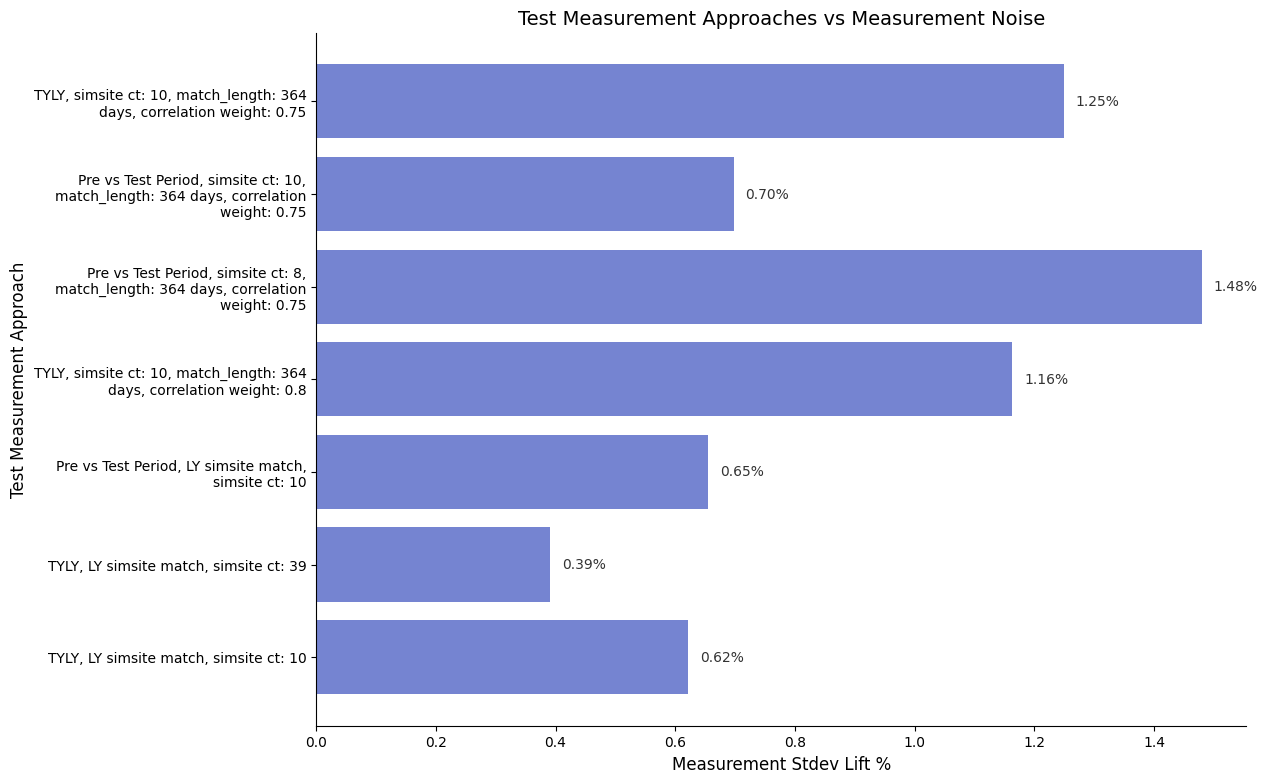

In [39]:
#results barchart and column chart Functions

#format the dataframe for charting
def add_newlines_to_all_columns(df, max_length=40):
    """
    Add newline characters to all columns in a DataFrame every max_length characters,
    ensuring that the text only breaks after completing a word.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns to process.
    max_length (int): The maximum length of characters before adding a newline (default is 40).
    
    Returns:
    pd.DataFrame: The DataFrame with modified columns.
    """
    def add_newlines(text, max_length):
        if not isinstance(text, str):
            return text
        words = text.split()
        lines = []
        current_line = ""

        for word in words:
            if len(current_line) + len(word) + 1 > max_length:
                lines.append(current_line)
                current_line = word
            else:
                if current_line:
                    current_line += " "
                current_line += word

        lines.append(current_line)  # Add the last line

        return '\n'.join(lines)

    for column in df.columns:
        df[column] = df[column].apply(lambda text: add_newlines(text, max_length))
    return df


def results_columnchart(results_df, label_char_width):
    add_newlines_to_all_columns(results_df, label_char_width)
    # Check for NaN values and remove them if necessary
    if results_df.isnull().values.any():
        print("Warning: DataFrame contains NaN values. Dropping rows with NaNs.")
        results_df = results_df.dropna()

    # Ensure 'Test_Params' and 'stdev' columns are of correct type
    results_df['Test_Params'] = results_df['Test_Params'].astype(str)
    results_df['stdev'] = results_df['stdev'].astype(float)

    # Debugging print to check the DataFrame before plotting
    print("DataFrame before plotting:")
    print(results_df)

    plt.figure(figsize=(12, 9))  # Adjust the figure size for better readability
    bars = plt.barh(results_df['Test_Params'], results_df['stdev'], color=(0.1, 0.2, 0.7, 0.6))
    plt.title("Test Measurement Approaches vs Measurement Noise", fontsize=14)
    plt.ylabel("Test Measurement Approach", fontsize=12)
    plt.xlabel("Measurement Stdev Lift %", fontsize=12)
    
    # Add text to the bars
    for bar in bars:
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', 
                 color=(0.0, 0.0, 0.0, 0.8), fontsize=10, va='center')

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

#print a column chart for the simulationn results
results_columnchart(barchart_df, 40)


In [ ]:
#to do: simulation = how many equivalent sites - best to worst

The dataset has a few outlier datapoints.  This function takes in the data and compares each datapoint adjusted for the week's 
average sales compared to other weeks, and the store's average sales compared to other stores.  This index view removes
differences in seasonal sales across dates, and differences in store sizes to create an index intended to find outliers.


In [17]:
# outlier index creation


# Function to create the outlier index
def create_outlier_index(total_store_sales):
    # Average sales for the entire dataset
    avg_sales = total_store_sales['Weekly_Sales'].mean()

    # Calculate average sales for each store and week
    store_avg_sales = total_store_sales.groupby('Store')['Weekly_Sales'].mean().rename('Store_Avg_Sales')
    weekly_avg_sales = total_store_sales.groupby('Date')['Weekly_Sales'].mean().rename('Week_Avg_Sales')

    # Merge the average sales back into the original DataFrame
    total_store_sales = total_store_sales.join(store_avg_sales, on='Store')
    total_store_sales = total_store_sales.join(weekly_avg_sales, on='Date')

    # Add chain average sales to each row
    total_store_sales['Chain_Avg_Sales'] = avg_sales

    # Calculate indexed values
    total_store_sales['Store_vs_Store_avg'] = total_store_sales['Store_Avg_Sales'] / avg_sales
    total_store_sales['Date_vs_avg'] = total_store_sales['Week_Avg_Sales'] / avg_sales

    # Creation of the outlier index
    total_store_sales['Outlier_Index'] = (
        total_store_sales['Weekly_Sales'] / 
        (total_store_sales['Store_vs_Store_avg'] * total_store_sales['Date_vs_avg'] * avg_sales) - 1
    )

    # Absolute value of index to flag potential outliers
    total_store_sales['Outlier_Abs'] = total_store_sales['Outlier_Index'].abs()

    return total_store_sales

total_store_sales_indexed = create_outlier_index(total_store_sales)



percent of datapoints flagged as outliers 1.82%


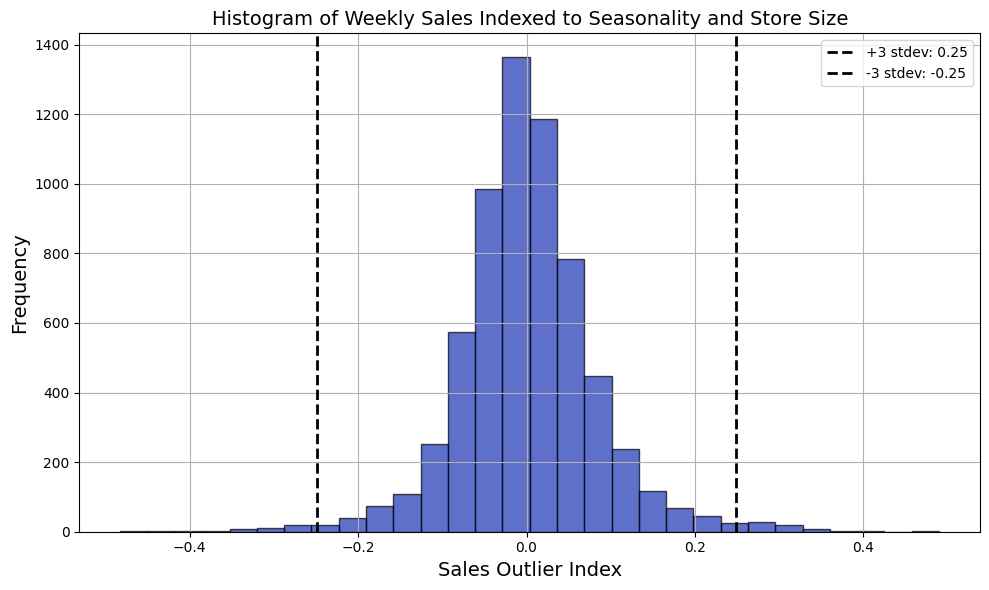

In [225]:
#print histogram of the outlier index
stdev_index = total_store_sales_indexed['Outlier_Index'].std()

print(f"percent of datapoints flagged as outliers {total_store_sales_indexed.loc[total_store_sales_indexed['Outlier_Abs'] > 0.25].shape[0]/total_store_sales_indexed.shape[0]*100:,.2f}%")

# Plotting the histogram of outlier index
plt.figure(figsize=(10, 6))
plt.hist(total_store_sales_indexed['Outlier_Index'], bins=30, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(stdev_index*3, color='black', linestyle='dashed', linewidth=2, label=f'+3 stdev: {stdev_index*3:,.2f}')
plt.axvline(-stdev_index*3, color='black', linestyle='dashed', linewidth=2, label=f'-3 stdev: {-stdev_index*3:,.2f}')
plt.title("Histogram of Weekly Sales Indexed to Seasonality and Store Size", fontsize=14)
plt.xlabel("Sales Outlier Index", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


The index has a flaw in that it assumes similar seasonality across stores.  Trend charts of the outliers highlight the error.  
Store 33 and store 38 don't have a sales boost during the holidays, but the index expects them to have one.
As a result, their sales index is 0 for the dates in red.  

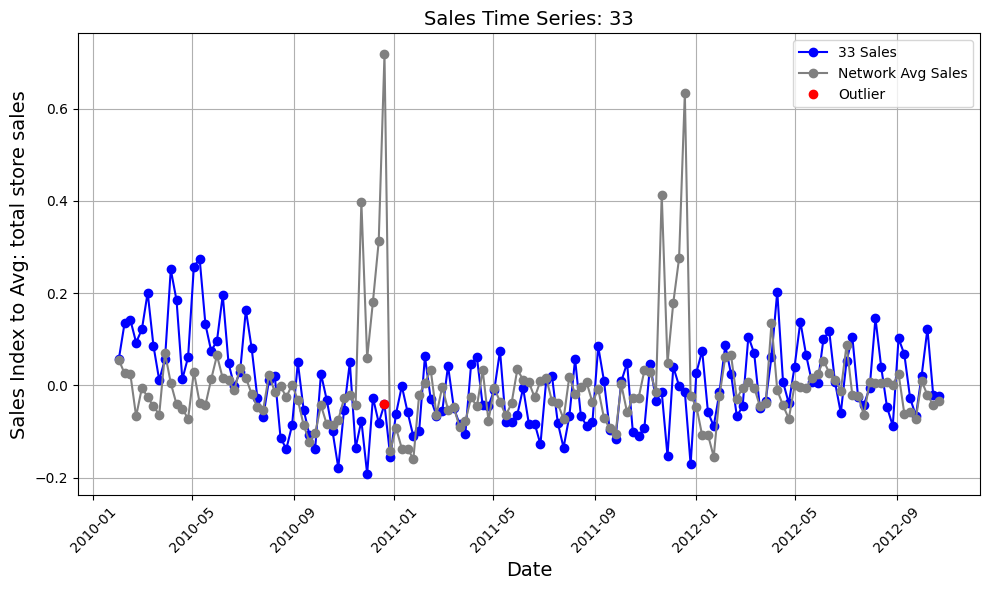

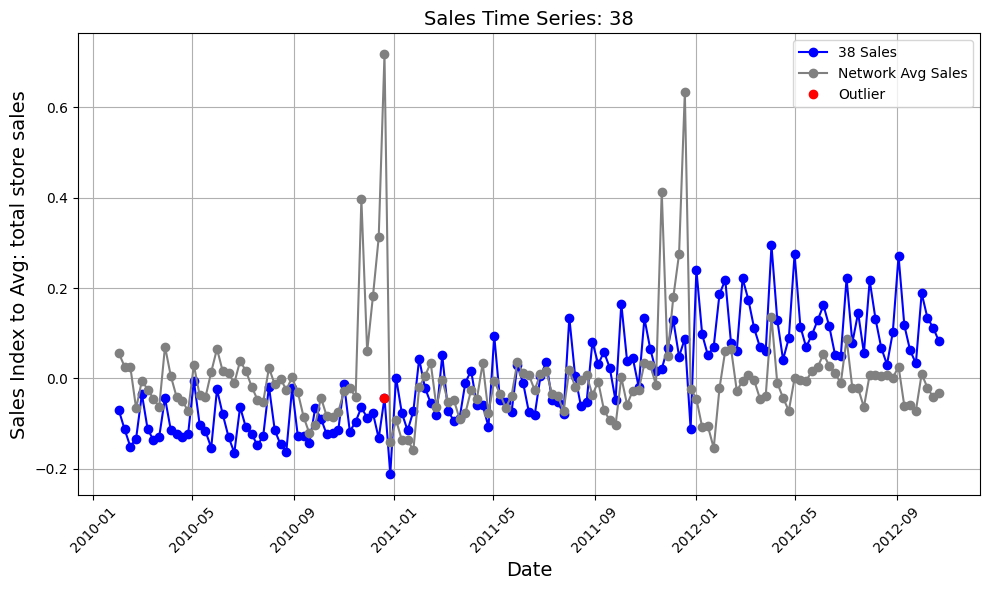

In [40]:
#investigate some of the outlier sites

def outlier_trend_chart(sales_dataframe, category, store_set, outlier_date, trend_line=False, index_value=False):
    """Take in a sales dataframe, category name, store set, and outlier date, plot the trend chart as a line graph with weekly average sales."""
    
    # Ensure the DataFrame has the necessary columns
    if 'Date' not in sales_dataframe.columns or 'Weekly_Sales' not in sales_dataframe.columns:
        raise ValueError("DataFrame must contain 'Date' and 'Weekly_Sales' columns.")
    
    # Convert 'Date' column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(sales_dataframe['Date']):
        sales_dataframe['Date'] = pd.to_datetime(sales_dataframe['Date'])
    
    # Ensure the 'Date' column is set to the start of the week
    sales_dataframe['Date'] = sales_dataframe['Date'] - pd.to_timedelta(sales_dataframe['Date'].dt.weekday, unit='d')
    
    # Group by 'Date' and calculate the mean 'Weekly_Sales' for each week
    weekly_sales = sales_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()

    # Convert outlier_date to datetime if it's not already
    outlier_date = pd.to_datetime(outlier_date)
    
    # Create trend line if requested
    if trend_line:
        weekly_sales['Date_num'] = pd.to_numeric(weekly_sales['Date'])
        coefficients = np.polyfit(weekly_sales['Date_num'], weekly_sales['Weekly_Sales'], 1)
        poly = np.poly1d(coefficients)
        weekly_sales['Trendline'] = poly(weekly_sales['Date_num'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label='Weekly Sales', color='blue', marker='o', linestyle='-')
    
    # Highlight the outlier date
    if outlier_date in weekly_sales['Date'].values:
        outlier_sales = weekly_sales[weekly_sales['Date'] == outlier_date]['Weekly_Sales'].values[0]
        plt.plot(outlier_date, outlier_sales, 'ro', label='Outlier')

    if trend_line:
        plt.plot(weekly_sales['Date'], weekly_sales['Trendline'], label='Line of Best Fit', linestyle='--', color='black')
    
    plt.title(f"Sales Time Series: {store_set}", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Sales: {category}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Ensure y-axis displays integer values with dollar signs
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))
    ax.set_ylim(bottom=0) 
    plt.tight_layout()
    plt.show()

def outlier_trend_chart_comparison(sales_dataframe, comparison_dataframe, category, store_set, outlier_dates, trend_line=False):
    """Plot sales trend chart with outliers for a store along with a comparison store's sales trend."""

    # Ensure the DataFrame has the necessary columns
    for df in [sales_dataframe, comparison_dataframe]:
        if 'Date' not in df.columns or 'Weekly_Sales' not in df.columns:
            raise ValueError("Both DataFrames must contain 'Date' and 'Weekly_Sales' columns.")
    
    # Convert 'Date' columns to datetime if they're not already
    for df in [sales_dataframe, comparison_dataframe]:
        if not pd.api.types.is_datetime64_any_dtype(df['Date']):
            df['Date'] = pd.to_datetime(df['Date'])
    
    # Ensure the 'Date' columns are set to the start of the week
    for df in [sales_dataframe, comparison_dataframe]:
        df['Date'] = df['Date'] - pd.to_timedelta(df['Date'].dt.weekday, unit='d')
    
    # Group by 'Date' and calculate the mean 'Weekly_Sales' for each week
    weekly_sales = sales_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()
    weekly_comparison = comparison_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()

    # Convert outlier_dates to datetime if they're not already
    outlier_dates = pd.to_datetime(outlier_dates)
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label= f'{store_set} Sales', color='blue', marker='o', linestyle='-')
    plt.plot(weekly_comparison['Date'], weekly_comparison['Weekly_Sales'], label='Network Avg Sales', color='gray', marker='o', linestyle='-')
    
    # Highlight the outlier dates    
    for outlier_date in outlier_dates:
        if outlier_date in weekly_sales['Date'].values:
            outlier_weekly_sales = weekly_sales[weekly_sales['Date'] == outlier_date]['Weekly_Sales'].values[0]
            plt.plot(outlier_date, outlier_weekly_sales, 'ro')

    # Add a single legend entry for outliers
    plt.plot([], [], 'ro', label='Outlier')
    
    plt.title(f"Sales Time Series: {store_set}", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Sales Index to Avg: {category}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
 
    
    # Ensure y-axis displays integer values with dollar signs
    ax = plt.gca()
    plt.tight_layout()
    plt.show()

#investigate some of the outlier sites
total_store_sales_index_outliers = total_store_sales_indexed[(total_store_sales_indexed['Outlier_Abs'] > 0.4)].copy()

#print(total_store_sales_index_outliers)

#examples of some of the outliers
"""
           Date  Store  Weekly_Sales  Store_Avg_Sales  Week_Avg_Sales  \
2102 2010-12-20     33     249246.80     2.598617e+05    1.798476e+06   
2107 2010-12-20     38     369106.72     3.857317e+05    1.798476e+06   
2111 2010-12-20     42     555075.27     5.564039e+05    1.798476e+06   
2121 2010-12-27      7     729572.08     5.706173e+05    8.985004e+05   
3707 2011-08-29     18     540922.94     1.084718e+06    1.008369e+06   
4445 2011-12-19     36     325262.46     3.735120e+05    1.711072e+06 
"""

#compare the store 33 outlier to the average store performance over time.  index each to its own average sales.
store1_trend = 33
date = '2010-12-20'
store1_trend_df = total_store_sales[(total_store_sales['Store'] == store1_trend)].copy()
store2_trend_df = total_store_sales.copy()
store1_trend_df_avg = store1_trend_df['Weekly_Sales'].mean()
store2_trend_df_avg = store2_trend_df['Weekly_Sales'].mean()
store1_trend_df['Weekly_Sales'] = store1_trend_df['Weekly_Sales'] / store1_trend_df_avg - 1
store2_trend_df['Weekly_Sales'] = store2_trend_df['Weekly_Sales'] / store2_trend_df_avg - 1

outliers = []
outliers.append(date)

#plot the store trend and outlier, compared against the total chain.
outlier_trend_chart_comparison(store1_trend_df, store2_trend_df,  "total store sales", store_set = f"{store1_trend}", outlier_dates = outliers)

#compare the store 33 outlier to the average store performance over time.  index each to its own average sales.
store1_trend = 38
date = '2010-12-20'
store1_trend_df = total_store_sales[(total_store_sales['Store'] == store1_trend)].copy()
store2_trend_df = total_store_sales.copy()
store1_trend_df_avg = store1_trend_df['Weekly_Sales'].mean()
store2_trend_df_avg = store2_trend_df['Weekly_Sales'].mean()
store1_trend_df['Weekly_Sales'] = store1_trend_df['Weekly_Sales'] / store1_trend_df_avg - 1
store2_trend_df['Weekly_Sales'] = store2_trend_df['Weekly_Sales'] / store2_trend_df_avg - 1

outliers = []
outliers.append(date)

#plot the store trend and outlier, compared against the total chain.
outlier_trend_chart_comparison(store1_trend_df, store2_trend_df,  "total store sales", store_set = f"{store1_trend}", outlier_dates = outliers)



To adjust out these false outliers, the outlier index for each store-date is compared to the outlier index for that store
in a different year,  if the comparison shows a similar index value, the outlier flag is removed.  Outliers are tracked using the
OutlierTrack class.

In [43]:

class OutlierTrack:
    """This class stores the outliers for a given store.  """
    def __init__(self, store, outlier_dates):
        self.store = store
        self.outlier_dates = outlier_dates

# Function to remove false positive outliers

def flag_outliers_vs_prior_year(total_store_sales, threshold=0.25):
    """inputs a sales dataframe, a threshold for outlier index.  For our data 0.25 represents 3 stdev"""

    total_store_sales['Outlier_Flag'] = False
    total_store_sales['YOY_Comparison_Index'] = 0.0
    
    one_year = pd.Timedelta(days=364)
    dates = total_store_sales['Date'].unique()
    stores = total_store_sales['Store'].unique()

    outliers_list = []

    for store in stores:
        store_outlier_list = []

        for date in dates:
            index = (total_store_sales['Store'] == store) & (total_store_sales['Date'] == date)

            #if not above the index outlier threshold, don't flag as an outlier
            if total_store_sales.loc[index, 'Outlier_Abs'].values[0] < threshold:
                continue

            #for the rest of the function, assume a datapoint is an outlier unless proven otherwise
            total_store_sales.loc[index, 'Outlier_Flag'] = True

            #for earlier dates in the dataset, compare the oulier index for the datapoint to the same store 1 year later
            #if the indexes are different by less than the threshold, remove the outlier flag
            if date <= pd.Timestamp('2011-09-01'):
                next_year_date = date + one_year
                next_year_index = (total_store_sales['Store'] == store) & (total_store_sales['Date'] == next_year_date)
                
                if next_year_index.any():
                    ratio_comparison = abs(total_store_sales.loc[index, 'Outlier_Index'].values[0] - 
                                           total_store_sales.loc[next_year_index, 'Outlier_Index'].values[0])
                    if ratio_comparison < threshold:
                        total_store_sales.loc[index, 'Outlier_Flag'] = False
            #for later dates in the dataset, compare the oulier index for the datapoint to the same store 1 year earlier
            #if the indexes are different by less than the threshold, remove the outlier flag
            else:
                previous_year_date = date - one_year
                previous_year_index = (total_store_sales['Store'] == store) & (total_store_sales['Date'] == previous_year_date)
                
                if previous_year_index.any():
                    ratio_comparison = abs(total_store_sales.loc[index, 'Outlier_Index'].values[0] - 
                                           total_store_sales.loc[previous_year_index, 'Outlier_Index'].values[0])
                    if ratio_comparison < threshold:
                        total_store_sales.loc[index, 'Outlier_Flag'] = False

            if total_store_sales.loc[index, 'Outlier_Flag'].values[0]:
                store_outlier_list.append(date)
                total_store_sales.loc[index, 'YOY_Comparison_Index'] = ratio_comparison

        store_outliers = OutlierTrack(store, store_outlier_list)
        if store_outliers.outlier_dates:
            outliers_list.append(store_outliers)

    return total_store_sales, outliers_list


total_store_sales_indexed, outliers_list = flag_outliers_vs_prior_year(total_store_sales_indexed)


Now print the remaining outliers. There are many fewer, and they are all correctly flagged as outliers.

count of all datapoints: 6435
count of final outliers list: 29
percent of data flagged as outlier 0.45%
count of stores with an outlier: 3


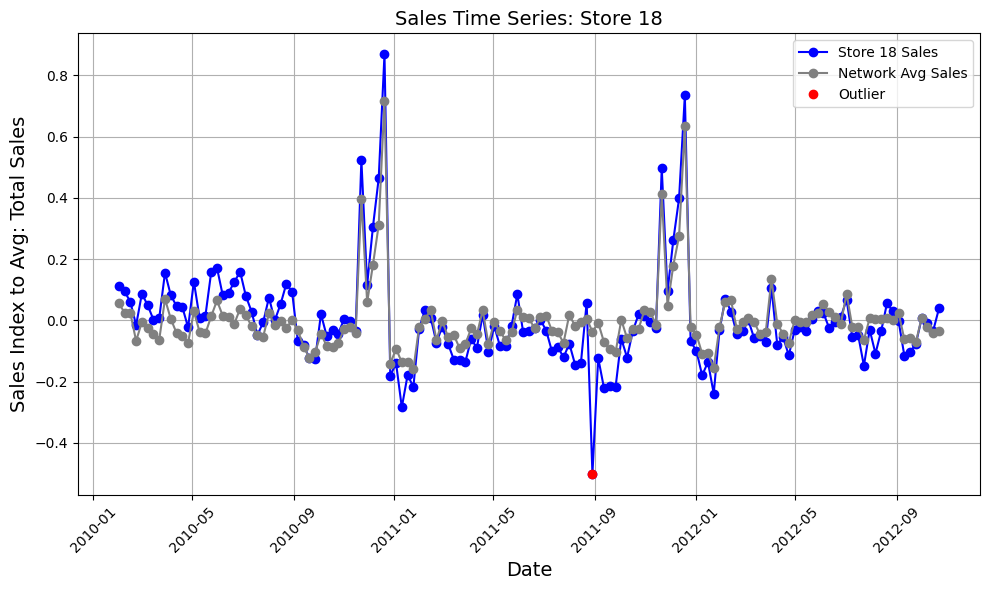

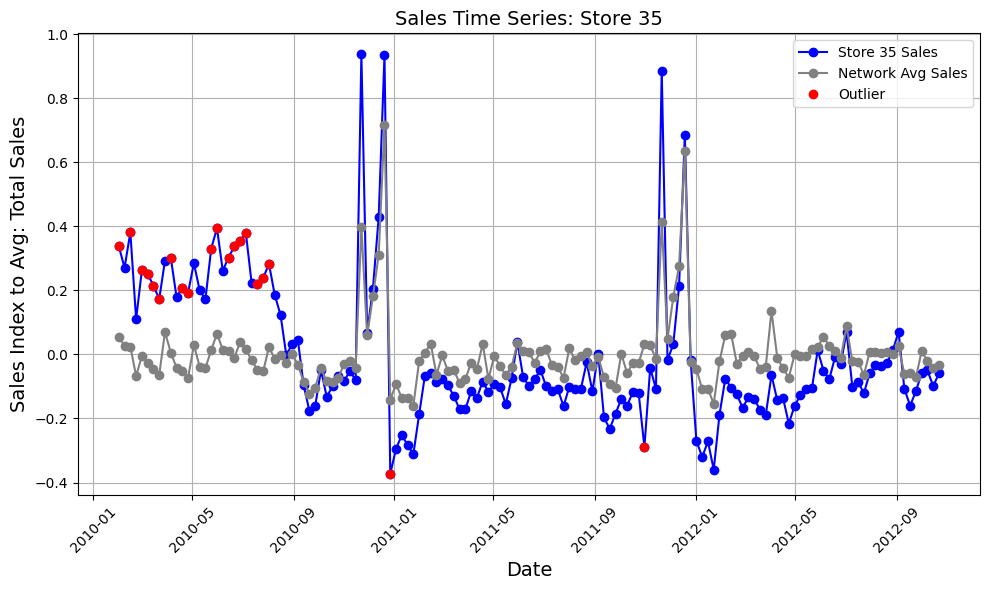

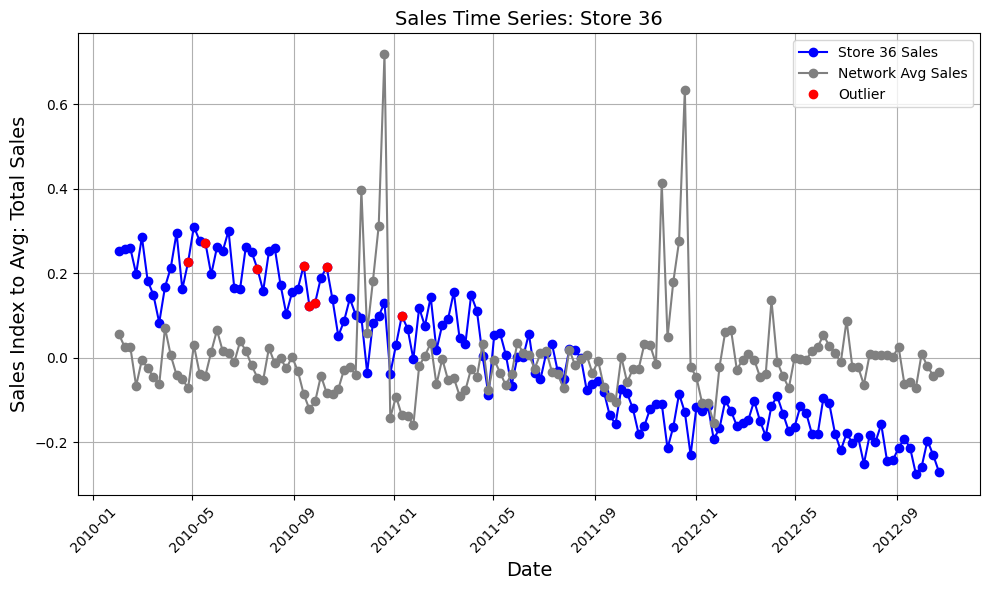

In [45]:
#print the outlier trend charts
total_store_sales_index_outliers = total_store_sales_indexed[(total_store_sales_indexed['Outlier_Flag'] == True)].copy()

#total_store_sales_index_outliers = total_store_sales_index_copy[(total_store_sales_index_copy['Outlier_Abs'] > 0.25)].copy()
print(f"count of all datapoints: {total_store_sales_indexed.shape[0]}")
print(f"count of final outliers list: {total_store_sales_index_outliers.shape[0]}")
print(f"percent of data flagged as outlier {total_store_sales_index_outliers.shape[0]/total_store_sales_indexed.shape[0]*100:,.2f}%")

#print trend charts for any store that has an outlier
stores_outliers_df = (list(set(total_store_sales_index_outliers['Store'])))
print(f"count of stores with an outlier: {len(outliers_list)}")
avg_sales = total_store_sales['Weekly_Sales'].mean()
plot_df = total_store_sales_indexed.copy()
plot_df['Weekly_Sales'] = plot_df['Weekly_Sales'] / avg_sales - 1
for store_results in outliers_list:
    store_trend = total_store_sales_indexed[total_store_sales_indexed['Store'] == store_results.store].copy()
    store_trend['Weekly_Sales'] = store_trend['Weekly_Sales'] / store_trend['Store_Avg_Sales'] - 1
    outlier_trend_chart_comparison(store_trend, plot_df, "Total Sales", store_set=f"Store {store_results.store}", outlier_dates = store_results.outlier_dates)




Now let's remove the outliers from the dataset. Two stores needed to be removed (35 and 36).  For simplicity I divided the 
store 18 outlier by 1/(1-index value).  A more thorough analysis would just ignore the datapoint anytime analysis of this 
site is done, however the index adjustment approach is sufficient for simulations

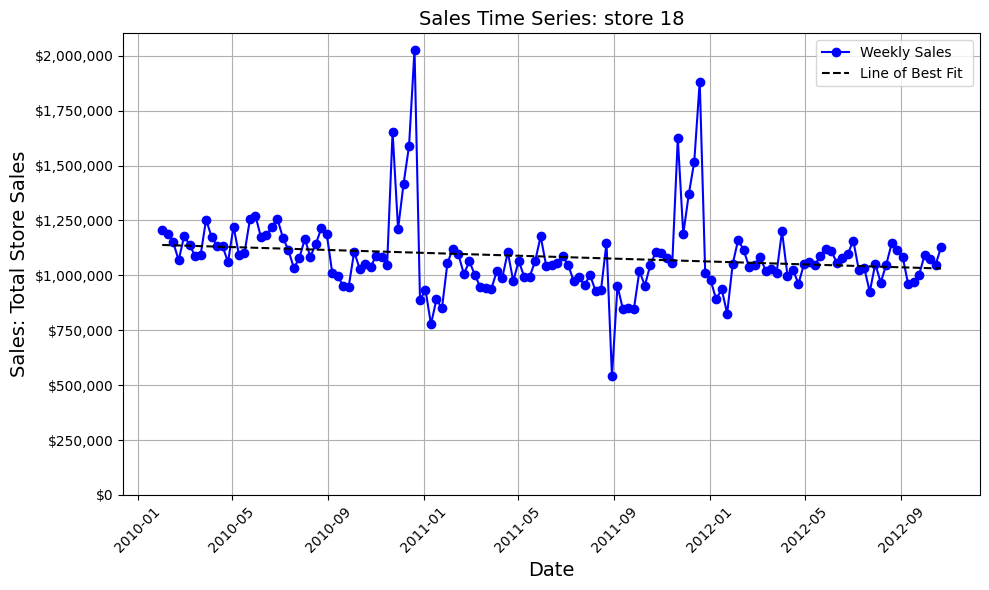

/var/folders/d8/81qn_kfs39x88w0868hpns480000gn/T/ipykernel_41705/3619614491.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] = total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] / (store_18_adj)


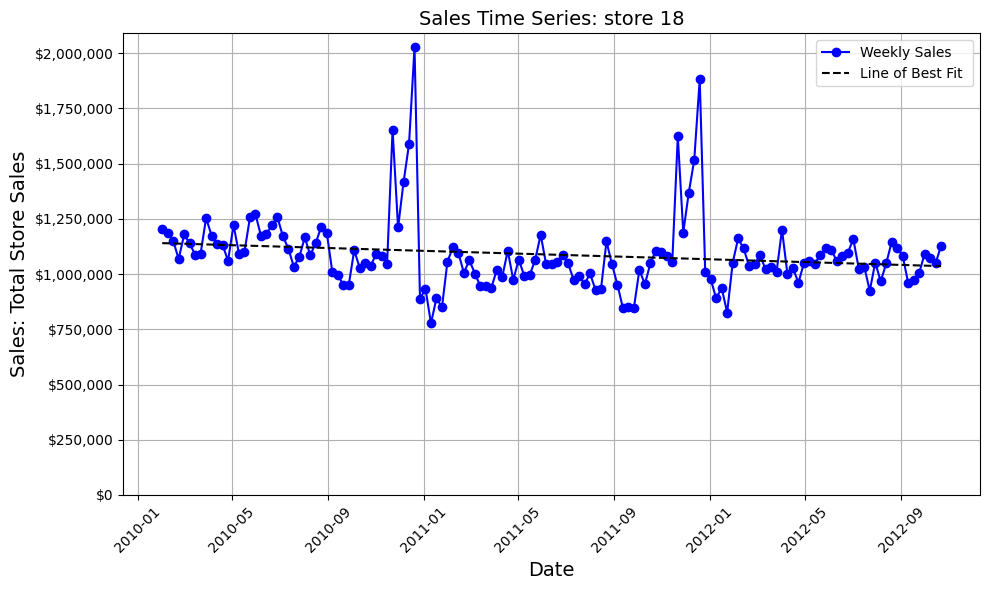

In [46]:
#remove the outliers

#drop 2 store outliers from dataset
#remove stores 35 and 36
total_store_sales_no_outliers = total_store_sales.loc[(total_store_sales['Store'] != 35) & (total_store_sales['Store'] != 36)].copy()


#adjust 18  on 8/29/2011 back up based on 1- it's index value.  print store 18 trend chart before and after
store_trend = 18
store_trend_df = total_store_sales_no_outliers[(total_store_sales_no_outliers['Store'] == store_trend)].copy()
trend_chart(store_trend_df, "Total Store Sales", store_set = f"store {store_trend}", trend_line=True, index_value=False)

#divide the outlier date by 1- the abs index value
store_18_adj = 1-total_store_sales_indexed['Outlier_Abs'].loc[(total_store_sales_indexed['Store'] == 18) & (total_store_sales_indexed['Date'] == '2011-08-29')]
total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] = total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] / (store_18_adj)

store_trend = 18
store_trend_df = total_store_sales_no_outliers[(total_store_sales_no_outliers['Store'] == store_trend)].copy()
trend_chart(store_trend_df, "Total Store Sales", store_set = f"store {store_trend}", trend_line=True, index_value=False)


Now let's simulate to understand how much measurement noise improvement comes from removing outliers.  

In [266]:
#create and run outlier removal simulations
# Create simulation scenarios as a list of dictionaries
test_plan_list = [
    {"max_simsites": 39, "match_length": 0, "TYLY_measurement_flag": True, "LY_match_flag": True, "match_type": 'simsites'},
]
# Turn the list of dictionaries into a DataFrame
test_plan_df = pd.DataFrame.from_records(test_plan_list)

print(test_plan_df)

# Assuming simulator is defined elsewhere
results_list_alltypes_w_outliers = simulator(total_store_sales, test_plan_df, pre_length=60, post_length=60, num_iterations=2, num_test_sites=5)
results_list_alltypes_test_no_outliers = simulator(total_store_sales_no_outliers, test_plan_df, pre_length=60, post_length=60, num_iterations=2, num_test_sites=5)

#mark the no outliers version and merge to a single result list
for i in range(0, len(results_list_alltypes_test_no_outliers)):
    results_list_alltypes_test_no_outliers[i].test_descrip = f'{results_list_alltypes_test_no_outliers[i].test_descrip} - no outliers' 
    print(results_list_alltypes_test_no_outliers[i].test_descrip)
    results_list_alltypes_w_outliers.append(results_list_alltypes_test_no_outliers[i])

# Summarize simulation results
results_df, barchart_df = summarize_results(results_list_alltypes_w_outliers)
filename = 'results_list_alltypes_w_outliers'

# Print the barchart DataFrame
print(barchart_df)

# Save results DataFrame to CSV
filepath = Path(f'/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/{filename}.csv') 
results_df.to_csv(filepath, index=False)


   max_simsites  match_length  TYLY_measurement_flag  LY_match_flag match_type
0            39             0                   True           True   simsites
plan iteration 0 sim iteration 0


plan iteration 0 sim iteration 1
plan iteration 0 sim iteration 0
plan iteration 0 sim iteration 1
TYLY, LY simsite match, simsite ct: 39 - no outliers
                                         Test_Params     stdev
0             TYLY, LY simsite match, simsite ct: 39  1.283355
1  TYLY, LY simsite match, simsite ct: 39 - no ou...  0.797397


These results are displayed in vertical bar chart becaus there are fewer examples to compare.

DataFrame before plotting:
                                         Test_Params     stdev
0             TYLY, LY simsite match, simsite ct: 39  1.283355
1  TYLY, LY simsite match, simsite ct: 39 -\nno o...  0.797397


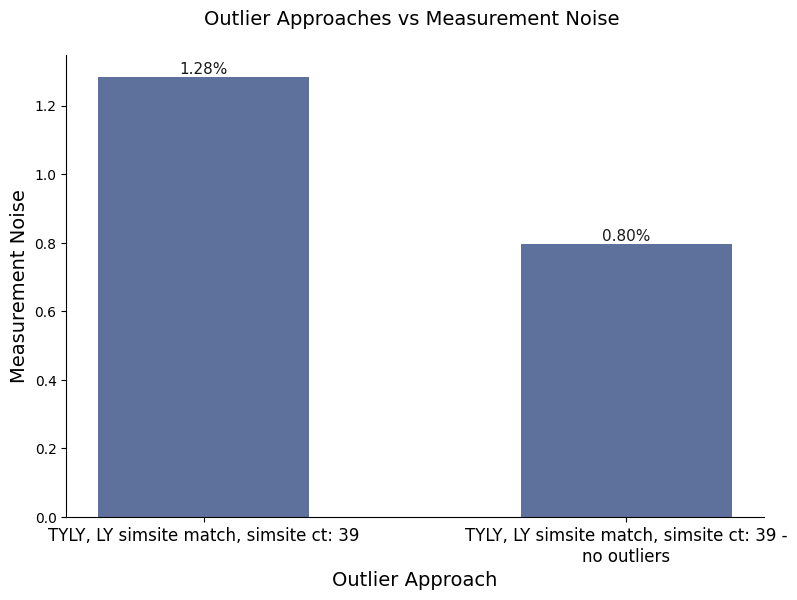

In [279]:
#create a barchart to compare simulation results
def results_barchart(results_df, label_char_width):
    add_newlines_to_all_columns(results_df, label_char_width)
    # Check for NaN values and remove them if necessary
    if results_df.isnull().values.any():
        print("Warning: DataFrame contains NaN values. Dropping rows with NaNs.")
        results_df = results_df.dropna()

    # Ensure 'Test_Params' and 'stdev' columns are of correct type
    results_df['Test_Params'] = results_df['Test_Params'].astype(str)
    results_df['stdev'] = results_df['stdev'].astype(float)

    # Debugging print to check the DataFrame before plotting
    print("DataFrame before plotting:")
    print(results_df)

    plt.figure(figsize=(9, 6))
    plt.bar(results_df['Test_Params'], results_df['stdev'], color=(0.1, 0.2, 0.45, 0.45), width=0.5)
    plt.title("Outlier Approaches vs Measurement Noise \n  ", fontsize=14)
    plt.xlabel("Outlier Approach", fontsize=14)
    plt.ylabel("Measurement Noise", fontsize=14)
    plt.xticks(fontsize = 12)
    bars = plt.bar(results_df['Test_Params'], results_df['stdev'], color=(0.1, 0.2, 0.45, 0.45), width=0.5)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=11, color =(0.0, 0.0, 0.0, 0.9))
        
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()



results_barchart(barchart_df, 40)

In [ ]:
#simulation - how many sites is equivalent to outlier removal?

Stores 35 and 36 see a long term sales decline.  I was curious if their YOY sales change would be flagged as an outlier.
The answer is yes.

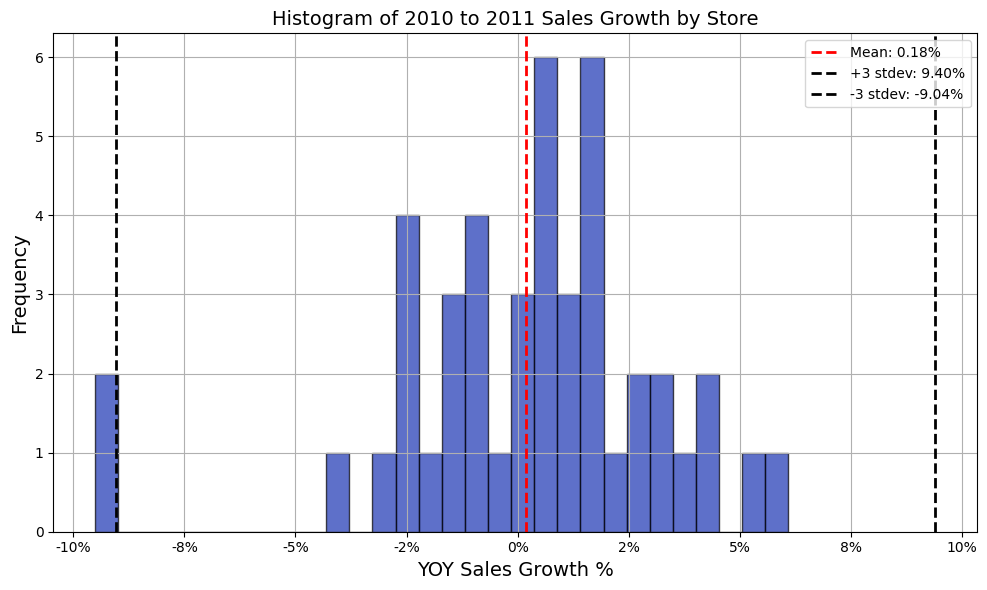

In [47]:
#creation of 2010 and 2011 sales values histogram - looking for outliers
total_store_sales_growth = total_store_sales.copy()
filtered_df_2010 = total_store_sales_growth[
    (total_store_sales_growth['Date'] >= '2010-02-05') &
    (total_store_sales_growth['Date'] < '2011-02-04')
].copy()

avg_2010_sales_by_store = avg_2010_sales_by_store = filtered_df_2010.groupby('Store')['Weekly_Sales'].mean().reset_index()
avg_2010_sales_by_store.columns = ['Store', 'avg_2010_sales']

filtered_df_2011 = total_store_sales_growth[
    (total_store_sales_growth['Date'] >= '2010-02-04') &
    (total_store_sales_growth['Date'] < '2012-02-03')
].copy()

avg_2011_sales_by_store = filtered_df_2011.groupby('Store')['Weekly_Sales'].mean().reset_index()
avg_2011_sales_by_store.columns = ['Store', 'avg_2011_sales']

#merge the 2011 table into the 2010 one for comparisons
avg_2010_sales_by_store = avg_2010_sales_by_store.merge(avg_2011_sales_by_store, on='Store')

#YOY sales growth creation
avg_2010_sales_by_store['yoy_growth'] = (avg_2010_sales_by_store['avg_2011_sales'] / avg_2010_sales_by_store['avg_2010_sales'] - 1)*100

#stdev and average growth used in the histogram
avg_growth = avg_2010_sales_by_store['yoy_growth'].mean()
stdev_growth = avg_2010_sales_by_store['yoy_growth'].std()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_2010_sales_by_store['yoy_growth'], bins=30, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(avg_growth, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_growth:,.2f}%')
plt.axvline(avg_growth + stdev_growth*3, color='black', linestyle='dashed', linewidth=2, label=f'+3 stdev: {avg_growth + stdev_growth*3:,.2f}%')
plt.axvline(avg_growth - stdev_growth*3, color='black', linestyle='dashed', linewidth=2, label=f'-3 stdev: {avg_growth - stdev_growth*3:,.2f}%')
plt.title("Histogram of 2010 to 2011 Sales Growth by Store", fontsize=14)
plt.xlabel("YOY Sales Growth %", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}%'))

plt.tight_layout()
plt.show()


